# 1. Problem Statement
1. Given questions on Quora, determine if they're duplicates of one another. 
2. This could be useful to quickly provide answers for questions which have already been answered
3. Task is to predict if two questions are duplicates or not

## 1.1 Business Objectives and Constraints
1. Cost of misclassification is high
2. Using probability (of pair of questions being duplicate) as a measure will be nice so that we can choose a threshold of choice. 

# 2. Machine Learning Problem
## 2.1 Data Overview
1. Train.csv contains 5 columns: </br>
    - qid1 - id of question 1 </br>
    - qid2 - id of question 2 </br>
    - question1 - english text of question 1 </br>
    - question2 - english text of question 2 </br>
    - is_duplicate - target column which indicates whether pair of questions are similar or not 
    

## 2.2 Type of Machine Learning Problem
1. It is a <strong>binary classification problem</strong>. Given a pair of questions, we need to predict if they are duplicate or not.

## 2.3 Performance Metric 
1. Log-loss (Primary KPI)
2. Confusion Matrix

# 3. Exploratory Data Analysis (EDA) and Train-Test Split

In [1]:
import warnings
warnings.filterwarnings("ignore") 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# reading data
df = pd.read_csv('train.csv').astype({
    'id': 'int32',
    'qid1': 'int32',
    'qid2': 'int32',
    'is_duplicate': 'int8'
})

In [3]:
# number of data-points
print(f'Number of data-points: {df.shape[0]}')

Number of data-points: 404290


In [4]:
# check top 5 points
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int32 
 1   qid1          404290 non-null  int32 
 2   qid2          404290 non-null  int32 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int8  
dtypes: int32(3), int8(1), object(2)
memory usage: 11.2+ MB


In [6]:
# checking count of null values in columns
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [7]:
# splitting the dataset early to avoid data leakage
# data will be split in 80:20 ratio 

from sklearn.model_selection import train_test_split

X = df.drop('is_duplicate', axis=1)
y = df['is_duplicate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

In [8]:
# check distribution of duplicate/ questions in train and test set

# train
count_of_0_train = y_train[y_train == 0].shape[0]
count_of_1_train = y_train[y_train == 1].shape[0]

# test
count_of_0_test = y_test[y_test == 0].shape[0]
count_of_1_test = y_test[y_test == 1].shape[0]

print(f'Pair of questions which are not duplicate (train set): {count_of_0_train}')
print(f'Pair of questions which are not duplicate (test set): {count_of_0_test}')

print('-'*50)

print(f'Pair of questions which are duplicate (train set): {count_of_1_train}')
print(f'Pair of questions which are duplicate (train set): {count_of_1_test}')

Pair of questions which are not duplicate (train set): 203839
Pair of questions which are not duplicate (test set): 51188
--------------------------------------------------
Pair of questions which are duplicate (train set): 119593
Pair of questions which are duplicate (train set): 29670


In [9]:
# get % of points which are duplicate/not duplicate in train and test set

per_of_0_train = np.round(count_of_0_train/(count_of_1_train+count_of_0_train)*100, 3)
per_of_1_train = np.round(count_of_1_train/(count_of_1_train+count_of_0_train)*100, 3)

per_of_0_test = np.round(count_of_0_test/(count_of_1_test+count_of_0_test)*100, 3)
per_of_1_test = np.round(count_of_1_test/(count_of_1_test+count_of_0_test)*100, 3)

print(f'Percentage of points which are not duplicate (train set): {per_of_0_train}')
print(f'Percentage of points which are not duplicate (test set): {per_of_0_test}')

print('-'*50)

print(f'Percentage of points which are duplicate (train set): {per_of_1_train}')
print(f'Percentage of points which are duplicate (test set): {per_of_1_test}')

Percentage of points which are not duplicate (train set): 63.024
Percentage of points which are not duplicate (test set): 63.306
--------------------------------------------------
Percentage of points which are duplicate (train set): 36.976
Percentage of points which are duplicate (test set): 36.694


### Observation:
1. Distribution of duplicate & non-duplicate question pairs is same in train and test

Total unique questions in both qid1 & qid2: 449887
Count of questions asked more than once in both qid1 & qid2: 85994 (19.1)
Max times a question was asked in both qid1 & qid2: 141


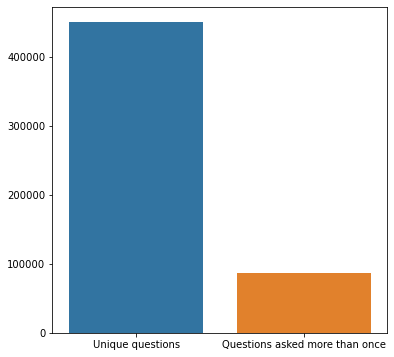

In [10]:
# get count of unique questions asked for qid1 and qid2

total_qids = X_train['qid1'].append(X_train['qid2'])
total_unique_qids = total_qids.nunique()
print(f'Total unique questions in both qid1 & qid2: {total_unique_qids}')

q_asked_more_than_once = np.sum(total_qids.value_counts() > 1)
q_asked_more_than_once_per = np.round(np.sum(total_qids.value_counts() > 1)/total_unique_qids, 3)
print(f'Count of questions asked more than once in both qid1 & qid2: {q_asked_more_than_once} ({q_asked_more_than_once_per*100})')

max_times_q_asked = total_qids.value_counts().iloc[0]
print(f'Max times a question was asked in both qid1 & qid2: {max_times_q_asked}')

plt.figure(figsize = (6, 6))
x = ['Unique questions', 'Questions asked more than once']
y = [total_unique_qids, q_asked_more_than_once]
 
sns.barplot(x, y);

In [11]:
# question which is asked 157 times in combined X_train
X_train.loc[X_train['qid1'] == total_qids.value_counts()[:1].index.values[0]].head(5)

,id,qid1,qid2,question1,question2
263505,263505,2559,380073,What are the best ways to lose weight?,Can I become slim by walking?
360010,360010,2559,75917,What are the best ways to lose weight?,Which are the best ways to lose weight?
346570,346570,2559,69079,What are the best ways to lose weight?,How can I lose an extreme amount of weight?
402909,402909,2559,190467,What are the best ways to lose weight?,How can you lose 5 pounds in 2 weeks safely?
115228,115228,2559,39426,What are the best ways to lose weight?,What are the ways of losing weight?


In [12]:
# question which is asked 157 times in combined X_train
X_train.loc[X_train['qid2'] == total_qids.value_counts()[:1].index.values[0]].head(5)

,id,qid1,qid2,question1,question2
137437,137437,219060,2559,Can I lose weight this way?,What are the best ways to lose weight?
364049,364049,320076,2559,How can I loose 10 kgs in 40 days?,What are the best ways to lose weight?
239584,239584,135652,2559,What should I take into account to try to lose...,What are the best ways to lose weight?
72964,72964,125274,2559,How can I lose 25 pounds in one month in a saf...,What are the best ways to lose weight?
79125,79125,15988,2559,How do I lose weight in 1 months?,What are the best ways to lose weight?


In [13]:
# count of most asked question  in question1 column 
print(f"Count of most asked question in question1 column: {X_train.loc[X_train['qid1'] == total_qids.value_counts()[:1].index.values[0]].shape[0]}")
print(f"Count of most asked question in question2 column: {X_train.loc[X_train['qid2'] == total_qids.value_counts()[:1].index.values[0]].shape[0]}")

Count of most asked question in question1 column: 40
Count of most asked question in question2 column: 101


In [14]:
# checking for duplicate rows
no_of_duplicates = X_train.loc[X_train.duplicated(keep='first')].shape[0]
print(f'Number of duplicate rows: {no_of_duplicates}')

Number of duplicate rows: 0


Max times a question was asked in both qid1 & qid2: 141


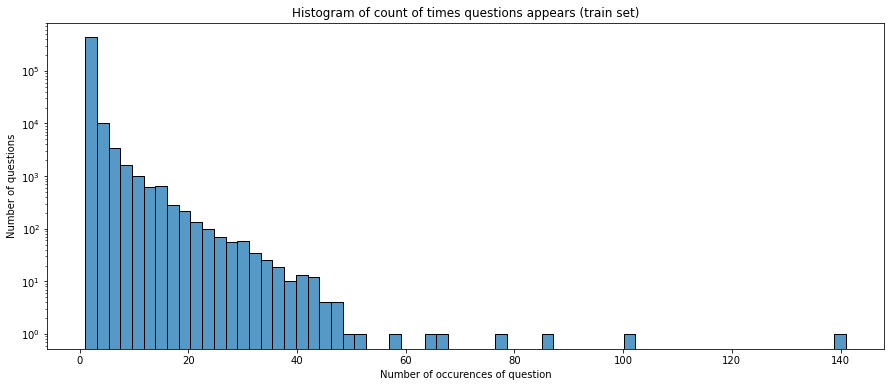

In [15]:
# check distribution of count of times a question was asked
print(f'Max times a question was asked in both qid1 & qid2: {max_times_q_asked}')

plt.figure(figsize = (15, 6))
plt.yscale('log')
plt.title('Histogram of count of times questions appears (train set)')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
sns.histplot(data=total_qids.value_counts(), bins=65);

In [16]:
# check rows which contain null values
X_train.loc[X_train.isna().any(axis=1)]

,id,qid1,qid2,question1,question2
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...
105780,105780,174363,174364,How can I develop android app?,NaN
201841,201841,303951,174364,How can I create an Android app?,NaN


In [17]:
# removing null values
og_shape = X_train.shape[0]
print(f'Shape of data before removing null values: {og_shape}')

null_indices_to_drop = X_train.loc[X_train.isna().any(axis=1)].index
X_train = X_train.drop(null_indices_to_drop)
y_train = y_train.drop(null_indices_to_drop)

shape_after_removal = X_train.shape[0]
print(f'Shape of data after removing null values: {shape_after_removal}')

Shape of data before removing null values: 323432
Shape of data after removing null values: 323429


# 4. Pre-processing of Text
- Removing html tags
- Removing Punctuations
- Performing stemming
- Removing Stopwords
- Expanding contractions etc.

In [18]:
# 5 sample rows which contain HTML tags in question1
X_train['question1'].loc[X_train['question1'].str.contains('<.*?>', regex=True)].head(10)

60039                            What is #include<stdio.h>?
272393    What is the difference between #include<stdio....
33357     Is this the correct way to implement a stack u...
137010    Why is the proxy class vector<bool>::reference...
54206     Avg antivirus 1800</v\>251<’-‘>4919 Avg tech s...
122918                                  What is <iostream>?
28609                       “><img src=x onerror=prompt(1)>
295447    How do we create an email script token in Mark...
344309    How exactly does the "sudo apt-get install <pa...
372266    What are the pros and <bold>cons</bold> of dem...
Name: question1, dtype: object

In [19]:
# 5 sample rows which contain HTML tags in question2
X_train['question2'].loc[X_train['question2'].str.contains('<.*?>', regex=True)].head(10)

60039                            What is #include<conio.h>?
281677           Is "do do … <noun>" grammatically correct?
206175    What are the pros and <bold>cons</bold> of dem...
319130    How can I split the string "[] {() <>} []" int...
28609                     "><img src=x onerror=prompt(0) >?
90618         <h1 style="color: blue;">HTML injection</h1>?
196271    What are the pros and <bold>cons</bold> of dem...
103511             What is the h for in #include <stdio.h>?
182126    How do I display a <div> table when a link is ...
337352    What are the pros and <bold>cons</bold> of dem...
Name: question2, dtype: object

In [20]:
import contractions
from nltk.stem import PorterStemmer

def preprocess_text(df, column):

    # transform to lower case
    df[column] =  df[column].str.lower()
    
    # replace symbols with currency string
    df[column] = df[column].replace("%", " percent ") \
                           .replace("₹", " rupee ") \
                           .replace("$", " dollar ") \
                           .replace("€", " euro ")
    
    # remove punctuations
    df[column] = df[column].str.replace(r'[^\w\s]+', '')
    
    # remove html tags
    # https://regex101.com/r/DthRSd/1
    # https://stackoverflow.com/questions/45999415/removing-html-tags-in-pandas
    df[column] = df[column].str.replace(r'<[^<>]*>', '', regex=True)
    
    # expand contractions
    df[column] = df[column].apply(lambda x: contractions.fix(x))
    
    # stemming
    porter = PorterStemmer()
    df[column] = df[column].apply(lambda x: porter.stem(x))
    
    # return X_train
    return df[column]

In [21]:
X_train['question1'] = preprocess_text(X_train, 'question1')
X_train['question2'] = preprocess_text(X_train, 'question2')
X_test['question1'] = preprocess_text(X_test, 'question1')
X_test['question2'] = preprocess_text(X_test, 'question2')

# 5. Feature Engineering
## 5.1 Feature Engineering-1 (Basic)

Constructing the following new features:
- <strong>q1len</strong> = Length of q1
- <strong>q2len</strong> = Length of q2
- <strong>q1_n_words</strong> = Number of words in Question 1
- <strong>q2_n_words</strong> = Number of words in Question 2
- <strong>word_common</strong> = (Number of common unique words in Question 1 and Question 2)
- <strong>word_total</strong> =(Total num of words in Question 1 + Total num of words in Question 2)
- <strong>word_share</strong> = (word_common)/(word_Total)

In [22]:
def get_basic_features(df, column1, column2):
    df['q1len'] = df[column1].str.len()
    df['q2len'] = df[column2].str.len()
    df['q1_n_words'] = df[column1].str.split(' ').str.len()
    df['q2_n_words'] = df[column2].str.split(' ').str.len()
    df['word_common'] = df.apply(lambda x: len(list(set(x[column1].lower().split(' '))&set(x[column2].lower().split(' ')))), axis=1)
    df['word_total'] = df.apply(lambda x: len(list(set(x[column1].lower().split(' '))))+len(list(set(x[column2].lower().split(' ')))), axis=1)
    df['word_share'] = df['word_common'].div(df['word_total'])   
    
    return df

In [23]:
# calling function on train and test
X_train = get_basic_features(X_train, 'question1', 'question2')
X_test = get_basic_features(X_test, 'question1', 'question2')

In [24]:
X_train.to_csv('x_train_basic_feature_engineering.csv', index=False)
X_test.to_csv('x_test_basic_feature_engineering.csv', index=False)

## 5.2 Feature Engineering-2 (Advanced)

Definition:

- <strong>Token :</strong> You get a token by splitting sentence by space </br>
- <strong>Stop_Word :</strong> stop words as per NLTK. </br>
- <strong>Word :</strong> A token that is not a stop_word </br>

Features: </br>

<strong>cwc_min</strong> : Ratio of common_word_count to min length of word count of Q1 and Q2</br> 
</br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))

<strong>cwc_max</strong> : Ratio of common_word_count to max length of word count of Q1 and Q2</br>
</br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))

<strong>csc_min</strong> : Ratio of common_stop_count to min length of stop count of Q1 and Q2</br>
csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))

<strong>csc_max</strong> : Ratio of common_stop_count to max length of stop count of Q1 and Q2</br>
csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))

<strong>ctc_min</strong> : Ratio of common_token_count to min length of token count of Q1 and Q2</br>
ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))


<strong>ctc_max</strong> : Ratio of common_token_count to max length of token count of Q1 and Q2</br>
ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))


<strong>last_word_eq</strong> : Check if Last word of both questions is equal or not</br>
last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])

<strong>first_word_eq</strong> : Check if First word of both questions is equal or not</br>
first_word_eq = int(q1_tokens[0] == q2_tokens[0])


<strong>abs_len_diff</strong> : Abs. length difference</br>
abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))


<strong>mean_len</strong> : Average Token Length of both Questions</br>
mean_len = (len(q1_tokens) + len(q2_tokens))/2


<strong>fuzz_ratio</strong> : https://github.com/seatgeek/fuzzywuzzy#usage </br>http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


<strong>fuzz_partial_ratio</strong>: https://github.com/seatgeek/fuzzywuzzy#usage </br>http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


<strong>token_sort_ratio</strong>: https://github.com/seatgeek/fuzzywuzzy#usage </br>http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

<strong>token_set_ratio</strong>: https://github.com/seatgeek/fuzzywuzzy#usage </br>http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

In [25]:
# importing stop-words
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')

# importing library for extracting fuzzy features
from fuzzywuzzy import fuzz

def get_advanced_features(df, df_y, column1, column2):

    # get sentence tokens
    df['q1_tokens'] = df[column1].str.split()
    df['q2_tokens'] = df[column2].str.split()

    # get non stop-words in questions
    df['q1_words'] = df['q1_tokens'].apply(lambda x: list(set([word for word in x if word not in STOP_WORDS])))
    df['q2_words'] = df['q2_tokens'].apply(lambda x: list(set([word for word in x if word not in STOP_WORDS])))

    # get stop-words in questions
    df['q1_stops'] = df['q1_tokens'].apply(lambda x: list(set([word for word in x if word in STOP_WORDS])))
    df['q2_stops'] = df['q2_tokens'].apply(lambda x: list(set([word for word in x if word in STOP_WORDS])))

    # https://stackoverflow.com/questions/66054517/find-common-words-in-two-columns-of-pandas-dataframe-consist-of-list-of-words

    # get common token count
    df['common_token_count'] = df.apply(lambda x: list(set(x['q1_tokens']).intersection(set(x['q2_tokens']))), axis=1).str.len()

    # get common word count
    df['common_word_count'] = df.apply(lambda x: list(set(x['q1_words']).intersection(set(x['q2_words']))), axis=1).str.len()

    # get common stop count
    df['common_stop_count'] = df.apply(lambda x: list(set(x['q1_stops']).intersection(set(x['q2_stops']))), axis=1).str.len()

    # creating features
    df['cwc_min'] = df['common_word_count']/np.minimum(df['q1_words'].str.len(), df['q2_words'].str.len())
    df['cwc_max'] = df['common_word_count']/np.maximum(df['q1_words'].str.len(), df['q2_words'].str.len())

    df['csc_min'] = df['common_stop_count']/np.minimum(df['q1_stops'].str.len(), df['q2_stops'].str.len())
    df['csc_max'] = df['common_stop_count']/np.maximum(df['q1_stops'].str.len(), df['q2_stops'].str.len())

    df['ctc_min'] = df['common_token_count']/np.minimum(df['q1_tokens'].str.len(), df['q2_tokens'].str.len())
    df['ctc_max'] = df['common_token_count']/np.maximum(df['q1_tokens'].str.len(), df['q2_tokens'].str.len())

    # removing rows where question length == 0
    rows_len_eq_0_q1 = df.loc[df['q1_tokens'].str.len() == 0].index
    rows_len_eq_0_q2 = df.loc[df['q2_tokens'].str.len() == 0].index
    df = df.drop(rows_len_eq_0_q1).drop(rows_len_eq_0_q2)
    df_y = df_y.drop(rows_len_eq_0_q1).drop(rows_len_eq_0_q2)
                        
    # check if 1st word is equal in question1 and question1 
    df['first_word_eq'] = df.apply(lambda x: 1.0 if x['q1_tokens'][0] == x['q1_tokens'][0] else 0.0, axis=1)
    
    # check if 1st word is equal in question1 and question1 
    df['last_word_eq'] = df.apply(lambda x: 1.0 if x['q1_tokens'][-1] == x['q2_tokens'][-1] else 0.0, axis=1)
    
    # absolute question length difference 
    df['abs_len_diff'] = df.apply(lambda x: abs(len(x['q1_tokens'])-len(x['q2_tokens'])), axis=1)
    
    # avg token length of both questions
    df['mean_len'] = df.apply(lambda x: (len(x['q1_tokens'])+len(x['q2_tokens']))/2, axis=1)
    
    # creating fuzzywuzzy features
    df['token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(x['question1'], x['question2']), axis=1)
    df['token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df['fuzz_ratio'] = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    
    # dropping irrelevant columns
    df = df.drop(['q1_tokens', 'q2_tokens', 'q1_words', 'q2_words', 'q1_stops', 'q2_stops', 'common_token_count', 'common_word_count', 'common_stop_count'], axis=1)
    
    # fillna with 0
    df = df.fillna(0, axis=1)
    
    df = df.round(3)
    
    return df, df_y

In [26]:
X_train, y_train = get_advanced_features(X_train, y_train, 'question1', 'question2')
X_test, y_test = get_advanced_features(X_test, y_test, 'question1', 'question2')

In [27]:
X_train.to_csv('x_train_advanced_feature_engineering.csv', index=False)
X_test.to_csv('x_test_advanced_feature_engineering.csv', index=False)

# 6. Analysis of Created Features
## 6.1 Feature Analysis: q1_n_words & q1_n_words 
- Few questions have only one word

In [28]:
print(f"Minimum words in a question1 (train set): {X_train['q1_n_words'].min()}")
print(f"Count of questions in question1 (train set) where number of words == 1: {X_train.loc[X_train.loc[X_train['q1_n_words'] == 1].index].shape[0]}")
print("Few questions in question1 column (train set) where word length is just one word: ")
X_train.loc[X_train.loc[X_train['q1_n_words'] == 1].index].head()[['question1', 'question2']]

Minimum words in a question1 (train set): 1
Count of questions in question1 (train set) where number of words == 1: 42
Few questions in question1 column (train set) where word length is just one word: 


,question1,question2
216861,aaa,my dad always yells at me and causes me anxiet...
245880,sss,what is sss
25315,delet,what kind of questions on quora are not ok wha...
248125,delet,how can i download flash season 2 episod
326297,how,what are some of the best ways to learn program


In [29]:
print(f"Minimum words in a question2 (train set): {X_train['q2_n_words'].min()}")
print(f"Count of questions in question2 (train set) where number of words == 1: {X_train.loc[X_train.loc[X_train['q2_n_words'] == 1].index].shape[0]}")
print("Few questions in question1 column (train set) where word length is just one word: ")
X_train.loc[X_train.loc[X_train['q2_n_words'] == 1].index].head()[['question1', 'question2']]

Minimum words in a question2 (train set): 1
Count of questions in question2 (train set) where number of words == 1: 15
Few questions in question1 column (train set) where word length is just one word: 


,question1,question2
144506,how beautiful do you think you ar,delet
322261,am i cursed with bad luck,delet
306878,is the electric field in the cavity of a hollo...,what
74304,is there any chances for hailstones tomorrow,parisflatlist
328745,lol,lol


## 6.2 Feature Analysis: 'word_share' 

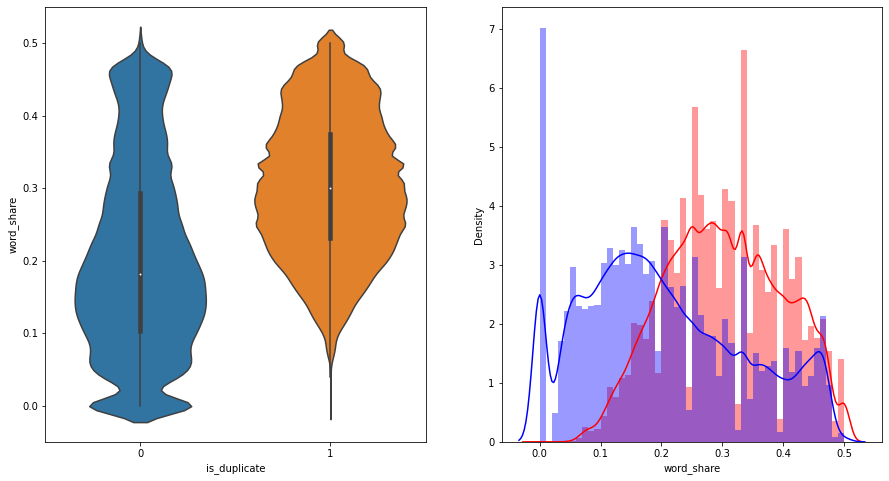

In [30]:
vis = X_train.merge(y_train, right_index=True, left_index=True)

plt.figure(figsize=(15, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = vis)

plt.subplot(1,2,2)
sns.distplot(vis[vis['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(vis[vis['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

<strong>Observations</strong>:
- There is massive overlap of distribution which implies there are many questions where words are similar 
- Average word share is greater then questions are duplicate 

## 6.3 Feature Analysis: 'word_common' 

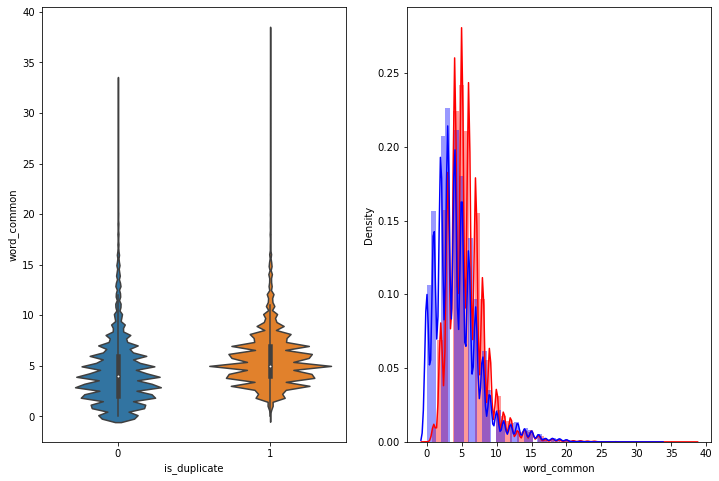

In [31]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_common', data = vis[0:])

plt.subplot(1,2,2)
sns.distplot(vis[vis['is_duplicate'] == 1.0]['word_common'][0:] , label = "1", color = 'red')
sns.distplot(vis[vis['is_duplicate'] == 0.0]['word_common'][0:] , label = "0" , color = 'blue' )
plt.show()

Observation:
- The distribution of common words for both duplicate and non-duplicate questions is highly overlapping 

## 6.4 Feature Analysis: WordCloud of question1 and question2  

In [32]:
from wordcloud import WordCloud, STOPWORDS

X_train_duplicate = vis.loc[vis['is_duplicate'] == 1]
X_train_nonduplicate = vis.loc[vis['is_duplicate'] == 0]

d = np.ravel([X_train_duplicate['question1'], X_train_duplicate['question2']])
nd = np.ravel([X_train_nonduplicate['question1'], X_train_nonduplicate['question2']])

### 6.4.1 WordCloud generated from duplicate questions

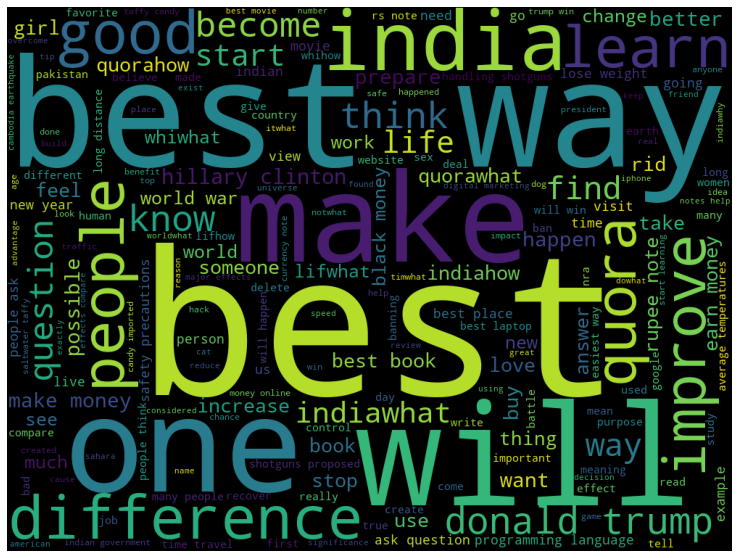

In [33]:
# wordcloud for questions which are duplicate

text = ''.join(d)

wordcloud = WordCloud(background_color='black', stopwords=STOPWORDS, height=750, width=1000).generate(text)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

### 6.4.2 WordCloud generated from non-duplicate question's

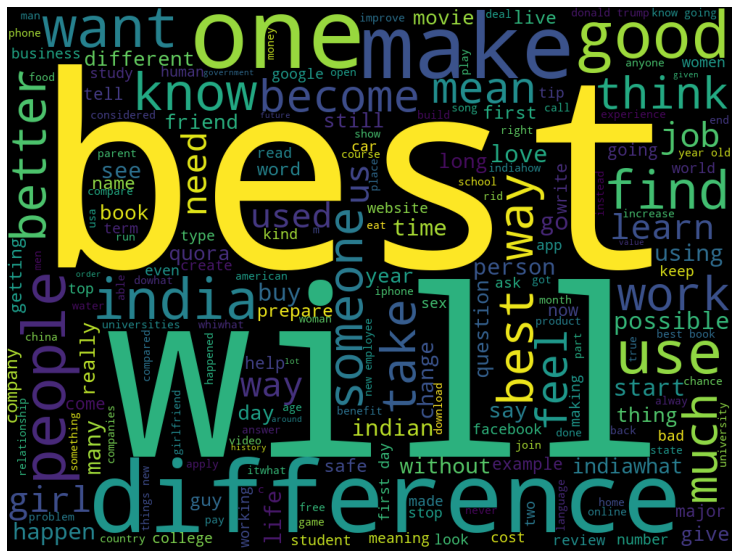

In [34]:
# wordcloud for questions which are not duplicate

text = ''.join(nd)

wordcloud = WordCloud(background_color='black', stopwords=STOPWORDS, height=750, width=1000).generate(text)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

## 6.5 Pairplot of Engineered Features (cwc_min, csc_min, ctc_min)

<Figure size 2160x720 with 0 Axes>

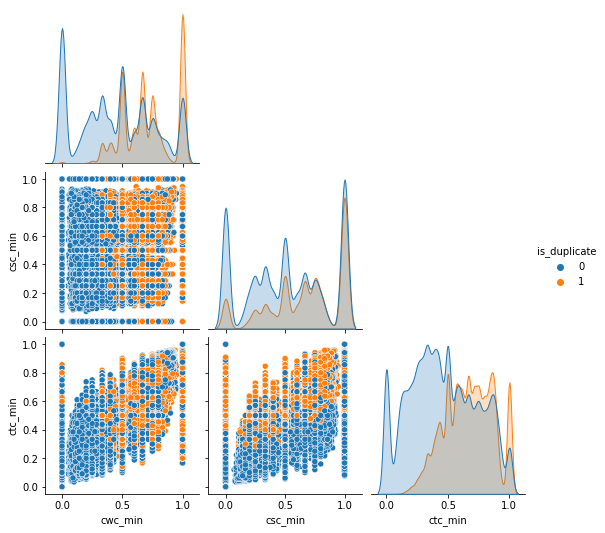

In [35]:
plt.figure(figsize=(30, 10))
sns.pairplot(vis[['cwc_min', 'csc_min', 'ctc_min', 'is_duplicate']], hue='is_duplicate', vars=['cwc_min', 'csc_min', 'ctc_min'], corner=True);

<strong>Observations</strong>
1. There is partial separability (also considerable overlap) using csc_min and ctc_min

## 6.6 Distribution of token_sort_ratio

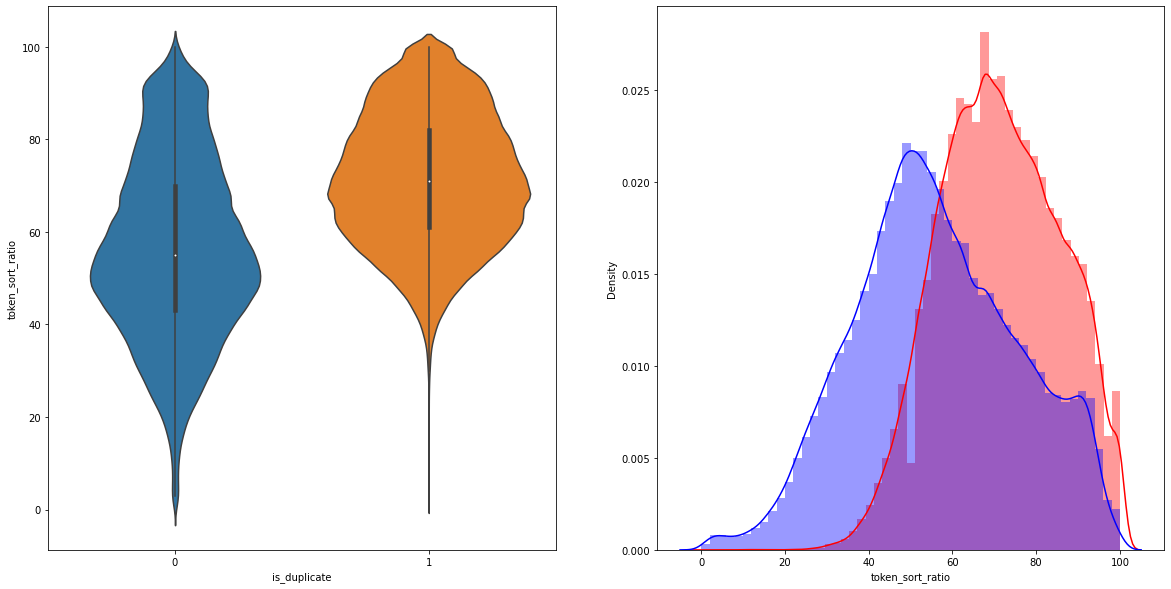

In [36]:
plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = vis)

plt.subplot(1,2,2)
sns.distplot(vis[vis['is_duplicate'] == 1.0]['token_sort_ratio'], label = "1", color = 'red')
sns.distplot(vis[vis['is_duplicate'] == 0.0]['token_sort_ratio'], label = "0" , color = 'blue' )
plt.show()

<strong>Observations</strong>
1. Although there is considerable overlap, duplicates (is_duplicate=1) tend to have higher token_sort_ratio values as compared to non-duplicate questions
2. 25th, 50th (median value) & 75th Percentile values of token_sort_ratio of duplicate questions is higher than token_sort_ratio of non-duplicate questions

## 6.7 Distribution of fuzz_ratio

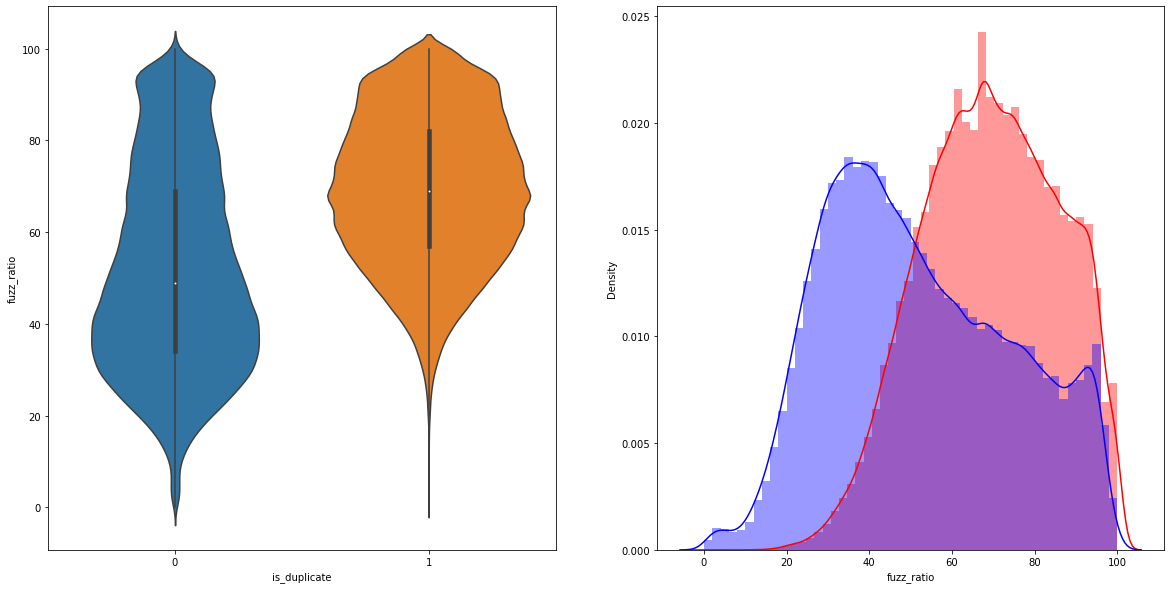

In [37]:
plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = vis)

plt.subplot(1,2,2)
sns.distplot(vis[vis['is_duplicate'] == 1.0]['fuzz_ratio'], label = "1", color = 'red')
sns.distplot(vis[vis['is_duplicate'] == 0.0]['fuzz_ratio'], label = "0" , color = 'blue' )
plt.show()

<strong>Observations</strong>
1. Duplicates (is_duplicate=1) tend to have higher fuzz_ratio values as compared to non duplicate questions
2. 25th, 50th (median value) & 75th Percentile values of fuzz_ratio of duplicate questions is higher than fuzz_ratio of non-duplicate questions

# 7. Visualizing using PCA (using Engineered Features)

In [38]:
# standardizing data before PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(vis.iloc[:, 6:].drop('is_duplicate', axis=1))

In [39]:
# applying PCA on standardized/scaled data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_train = pca.fit_transform(scaled_data)

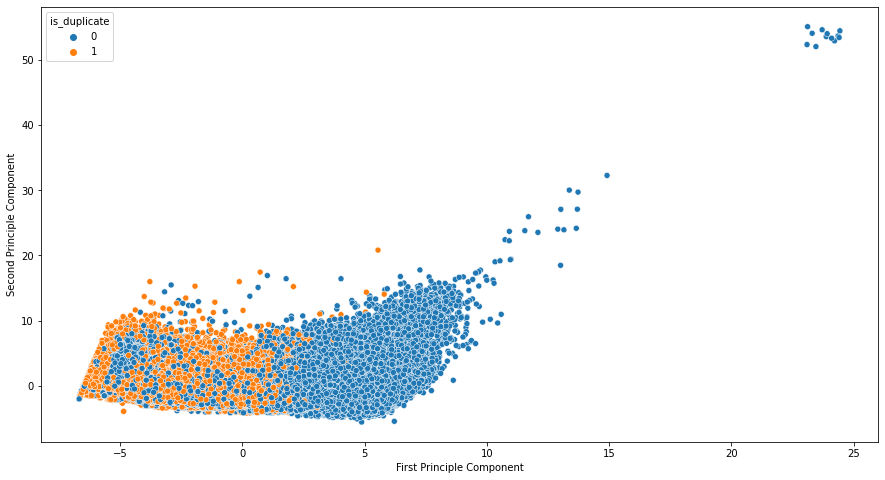

In [40]:
# plotting 1st and 2nd prinipal components
plt.figure(figsize=(15, 8))
sns.scatterplot(x = pca_train[:, 0], y = pca_train[:, 1], hue = vis['is_duplicate'])
plt.xlabel('First Principle Component')
plt.ylabel('Second Principle Component');

<strong>Observation</strong>
1. We can see using PCA that data is almost linearly separable with considerable overlap
2. Using a ML model, we're most likely to misclassify duplicates as non-duplicates as there are many blue points within the vicinity of orange points in the plot

# 8. Encoding text data using TFIDF and Bag of Words 
## 8.1. Featurizing text data using TF-IDF

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

# considering only those words which occur atleast 10 times 
vectorizer_tfidf_q1 = TfidfVectorizer(lowercase=True, min_df=10)
vectorizer_tfidf_q2 = TfidfVectorizer(lowercase=True, min_df=10)

# fit_transform on train
tfidf_train_q1 = vectorizer_tfidf_q1.fit_transform(X_train['question1'].values)
tfidf_q1_X_train = pd.DataFrame.sparse.from_spmatrix(tfidf_train_q1, columns=vectorizer_tfidf_q1.get_feature_names())

tfidf_train_q2 = vectorizer_tfidf_q2.fit_transform(X_train['question2'].values)
tfidf_q2_X_train = pd.DataFrame.sparse.from_spmatrix(tfidf_train_q2, columns=vectorizer_tfidf_q2.get_feature_names())

# set appropriate index
tfidf_q1_X_train = tfidf_q1_X_train.set_index(X_train.index)
tfidf_q2_X_train = tfidf_q2_X_train.set_index(X_train.index)

# transform on test
tfidf_test_q1 = vectorizer_tfidf_q1.transform(X_test['question1'].values)
tfidf_q1_X_test = pd.DataFrame.sparse.from_spmatrix(tfidf_test_q1, columns=vectorizer_tfidf_q1.get_feature_names())

tfidf_test_q2 = vectorizer_tfidf_q2.transform(X_test['question2'].values)
tfidf_q2_X_test = pd.DataFrame.sparse.from_spmatrix(tfidf_test_q2, columns=vectorizer_tfidf_q2.get_feature_names())

# set appropriate index
tfidf_q1_X_test = tfidf_q1_X_test.set_index(X_test.index)
tfidf_q2_X_test = tfidf_q2_X_test.set_index(X_test.index)

## 8.2. Featurizing text data using Bag of Words

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

# considering only those words which occur atleast 10 times 
vectorizer_bow_q1 = CountVectorizer(lowercase=True, min_df=10)
vectorizer_bow_q2 = CountVectorizer(lowercase=True, min_df=10)

# fit_transform on train
bow_train_q1 = vectorizer_bow_q1.fit_transform(X_train['question1'].values)
bow_q1_X_train = pd.DataFrame.sparse.from_spmatrix(bow_train_q1, columns=vectorizer_bow_q1.get_feature_names())

bow_train_q2 = vectorizer_bow_q2.fit_transform(X_train['question2'].values)
bow_q2_X_train = pd.DataFrame.sparse.from_spmatrix(bow_train_q2, columns=vectorizer_bow_q2.get_feature_names())

# set appropriate index
bow_q1_X_train = bow_q1_X_train.set_index(X_train.index)
bow_q2_X_train = bow_q2_X_train.set_index(X_train.index)

# transform on test
bow_test_q1 = vectorizer_bow_q1.transform(X_test['question1'].values)
bow_q1_X_test = pd.DataFrame.sparse.from_spmatrix(bow_test_q1, columns=vectorizer_bow_q1.get_feature_names())

bow_test_q2 = vectorizer_bow_q2.transform(X_test['question2'].values)
bow_q2_X_test = pd.DataFrame.sparse.from_spmatrix(bow_test_q2, columns=vectorizer_bow_q2.get_feature_names())

# set appropriate index
bow_q1_X_test = bow_q1_X_test.set_index(X_test.index)
bow_q2_X_test = bow_q2_X_test.set_index(X_test.index)

## 8.3. Label encoding y_train and y_test 

In [43]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print(f'Label encoded y_train array: {y_train}')
print(f'Label encoded y_test array: {y_test}')

print(f'Number of classes: {le.classes_}')

Label encoded y_train array: [0 1 0 ... 0 0 1]
Label encoded y_test array: [0 0 0 ... 0 1 0]
Number of classes: [0 1]


# 9. Preparing final data to feed into model

In [44]:
# basic features
X_train.iloc[:, 3:12].head(2)

,question1,question2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share
320292,why do our faces look puffy in the morning jus...,what is the first thing you do after you wake ...,63,60,13,14,5,25,0.200
227727,how can one pass a hair folicle test for meth ...,can hair dye help pass a hair follicle drug te...,64,68,14,14,7,27,0.259


In [45]:
# advanced features
X_train.iloc[:, 13:].head(2)

,cwc_max,csc_min,csc_max,ctc_min,ctc_max,first_word_eq,last_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
320292,0.0,0.625,0.625,0.385,0.357,1.0,0.0,1,13.5,63,59,42,37
227727,0.4,1.000,0.429,0.500,0.500,1.0,0.0,0,14.0,71,65,62,63


In [46]:
# tfidf features
tfidf_q1_X_train.head(2)

,00,01,05,10,100,1000,10000,100000,1000000,1000r,...,zombie,zon,zone,zones,zoo,zoology,zoom,zs,zuckerberg,zynga
320292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
227727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# tfidf features
tfidf_q2_X_train.head(2)

,00,01,05,10,100,1000,10000,100000,1000000,1000rs,...,zomato,zombie,zon,zone,zones,zoo,zoom,zs,zuckerberg,zynga
320292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
227727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# Bag of words features
bow_q1_X_train.head(2)

,00,01,05,10,100,1000,10000,100000,1000000,1000r,...,zombie,zon,zone,zones,zoo,zoology,zoom,zs,zuckerberg,zynga
320292,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
227727,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
# Bag of words features
bow_q2_X_train.head(2)

,00,01,05,10,100,1000,10000,100000,1000000,1000rs,...,zomato,zombie,zon,zone,zones,zoo,zoom,zs,zuckerberg,zynga
320292,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
227727,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 9.1. Final Data for Naive Bayes (Standard Scaling not required)

In [50]:
from scipy.sparse import csr_matrix, hstack

X_train_nb_tfidf = hstack((csr_matrix(X_train.iloc[:, 5:]), tfidf_train_q1, tfidf_train_q2))
X_test_nb_tfidf = hstack((csr_matrix(X_test.iloc[:, 5:]), tfidf_test_q1, tfidf_test_q2))

X_train_nb_bow = hstack((csr_matrix(X_train.iloc[:, 5:]), bow_train_q1, bow_train_q2))
X_test_nb_bow = hstack((csr_matrix(X_test.iloc[:, 5:]), bow_test_q1, bow_test_q2))

## 9.2. Final Data for Logistic Regression (Standard Scaling required)

In [51]:
from sklearn.preprocessing import StandardScaler
scaler_lr = StandardScaler()

X_train_scaled = scaler_lr.fit_transform(X_train.iloc[:, 5:])
X_test_scaled = scaler_lr.transform(X_test.iloc[:, 5:])

In [52]:
X_train_lr_tfidf = hstack((csr_matrix(X_train_scaled), tfidf_train_q1, tfidf_train_q2))
X_test_lr_tfidf = hstack((csr_matrix(X_test_scaled), tfidf_test_q1, tfidf_test_q2))

X_train_lr_bow = hstack((csr_matrix(X_train_scaled), bow_train_q1, bow_train_q2))
X_test_lr_bow = hstack((csr_matrix(X_test_scaled), bow_test_q1, bow_test_q2))

In [53]:
# save all sparse matrices 
from scipy.sparse import save_npz

# final sparse matrix data to train on naive bayes tfidf (train & test)
save_npz("X_train_nb_tfidf.npz", X_train_nb_tfidf)
save_npz("X_test_nb_tfidf.npz", X_test_nb_tfidf)

# final sparse matrix data to train on naive bayes bow (train & test)
save_npz("X_train_nb_bow.npz", X_train_nb_bow)
save_npz("X_test_nb_bow.npz", X_test_nb_bow)

# final sparse matrix data to train on logistic regression tfidf (train & test)
save_npz("X_train_lr_tfidf.npz", X_train_lr_tfidf)
save_npz("X_test_lr_tfidf.npz", X_test_lr_tfidf)

# final sparse matrix data to train on logistic regression bow (train & test)
save_npz("X_train_lr_bow.npz", X_train_lr_bow)
save_npz("X_test_lr_bow.npz", X_test_lr_bow)

# sparse train and test target column
save_npz("y_train.npz", csr_matrix(y_train))
save_npz("y_test.npz", csr_matrix(y_test))

# 10. Applying Machine Learning Models
## 10.1. Load Data

In [1]:
import warnings
warnings.filterwarnings("ignore") 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from scipy.sparse import load_npz

# load naive bayes - tfidf
X_train_nb_tfidf = load_npz('X_train_nb_tfidf.npz')
X_test_nb_tfidf = load_npz('X_test_nb_tfidf.npz')

# load naive bayes - bow
X_train_nb_bow = load_npz('X_train_nb_bow.npz')
X_test_nb_bow = load_npz('X_test_nb_bow.npz')

# load logistic regression - tfidf
X_train_lr_tfidf = load_npz('X_train_lr_tfidf.npz')
X_test_lr_tfidf = load_npz('X_test_lr_tfidf.npz')

# load logistic regression - bow
X_train_lr_bow = load_npz('X_train_lr_bow.npz')
X_test_lr_bow = load_npz('X_test_lr_bow.npz')

y_train = load_npz('y_train.npz').toarray().ravel().T
y_test = load_npz('y_test.npz').toarray().ravel().T

## 10.2. Naive Bayes (TFIDF)

For value of alpha: 0.005, log-loss is 0.5907
For value of alpha: 0.01, log-loss is 0.5909
For value of alpha: 0.1, log-loss is 0.5916
For value of alpha: 0.5, log-loss is 0.5925
For value of alpha: 1.0, log-loss is 0.5931
For value of alpha: 5.0, log-loss is 0.5954
--------------------------------------------------
For best value of alpha: 0.005, the train log-loss is 0.5913
For best value of alpha: 0.005, the test log-loss is 0.5907


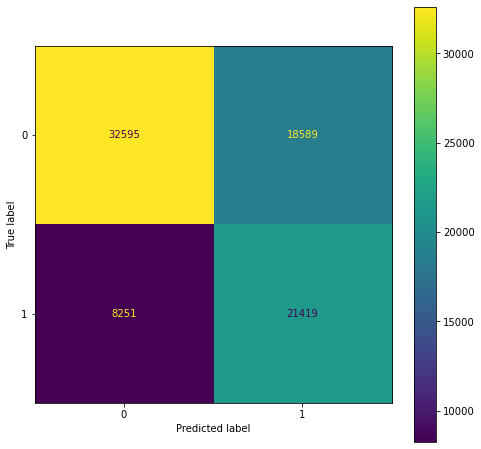

In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, plot_confusion_matrix

alpha = [0.005, 0.01, 0.1, 0.5, 1.0, 5.0]

log_error_array = []

for i in alpha:
    clf_nb = MultinomialNB(alpha=i)
    sig_clf = CalibratedClassifierCV(clf_nb)
    sig_clf.fit(X_train_nb_tfidf, y_train)
    predict_y = sig_clf.predict_proba(X_test_nb_tfidf)
    log_error_array.append(np.round(log_loss(y_test, predict_y), 4))
    print(f'For value of alpha: {i}, log-loss is {np.round(log_loss(y_test, predict_y), 4)}')

print('-'*50)

best_alpha_tfidf = alpha[np.argmin(log_error_array)]
clf = MultinomialNB(alpha = best_alpha_tfidf)
sig_clf = CalibratedClassifierCV(clf)
sig_clf.fit(X_train_nb_tfidf, y_train)

predict_y = sig_clf.predict_proba(X_train_nb_tfidf)
logloss_train_nb_tfidf = np.round(log_loss(y_train, predict_y), 4)
print(f'For best value of alpha: {best_alpha_tfidf}, the train log-loss is {logloss_train_nb_tfidf}')

predict_y = sig_clf.predict_proba(X_test_nb_tfidf)
logloss_test_nb_tfidf = np.round(log_loss(y_test, predict_y), 4)
print(f'For best value of alpha: {best_alpha_tfidf}, the test log-loss is {logloss_test_nb_tfidf}')

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(sig_clf, X_test_nb_tfidf, y_test, values_format='.0f', ax=ax);

## 10.3. Naive Bayes (Bag of Words)

For value of alpha: 0.005, log-loss is 0.5717
For value of alpha: 0.01, log-loss is 0.572
For value of alpha: 0.1, log-loss is 0.573
For value of alpha: 0.5, log-loss is 0.5739
For value of alpha: 1.0, log-loss is 0.5746
For value of alpha: 5.0, log-loss is 0.5776
--------------------------------------------------
For best value of alpha: 0.005, the train log-loss is 0.571
For best value of alpha: 0.005, the test log-loss is 0.5717


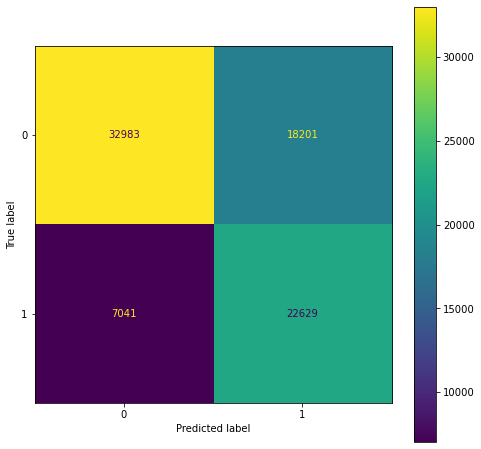

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, plot_confusion_matrix

alpha = [0.005, 0.01, 0.1, 0.5, 1.0, 5.0]

log_error_array = []

for i in alpha:
    clf_nb = MultinomialNB(alpha=i)
    sig_clf = CalibratedClassifierCV(clf_nb)
    sig_clf.fit(X_train_nb_bow, y_train)
    predict_y = sig_clf.predict_proba(X_test_nb_bow)
    log_error_array.append(np.round(log_loss(y_test, predict_y), 4))
    print(f'For value of alpha: {i}, log-loss is {np.round(log_loss(y_test, predict_y), 4)}')

print('-'*50)

best_alpha_bow = alpha[np.argmin(log_error_array)]
clf = MultinomialNB(alpha = best_alpha_bow)
sig_clf = CalibratedClassifierCV(clf)
sig_clf.fit(X_train_nb_bow, y_train)

predict_y = sig_clf.predict_proba(X_train_nb_bow)
logloss_train_nb_bow = np.round(log_loss(y_train, predict_y), 4)
print(f'For best value of alpha: {best_alpha_bow}, the train log-loss is {logloss_train_nb_bow}')

predict_y = sig_clf.predict_proba(X_test_nb_bow)
logloss_test_nb_bow = np.round(log_loss(y_test, predict_y), 4)
print(f'For best value of alpha: {best_alpha_bow}, the test log-loss is {logloss_test_nb_bow}')

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(sig_clf, X_test_nb_bow, y_test, values_format='.0f', ax=ax);

## 10.2. Logistic Regression (TFIDF)

For value of C: 0.005, log-loss is 0.4777
For value of C: 0.01, log-loss is 0.4628
For value of C: 0.1, log-loss is 0.4281
For value of C: 0.5, log-loss is 0.4242
For value of C: 1.0, log-loss is 0.422
For value of C: 5.0, log-loss is 0.4236
--------------------------------------------------
For best value of C: 1.0, the train log-loss is 0.4101
For best value of C: 1.0, the test log-loss is 0.422


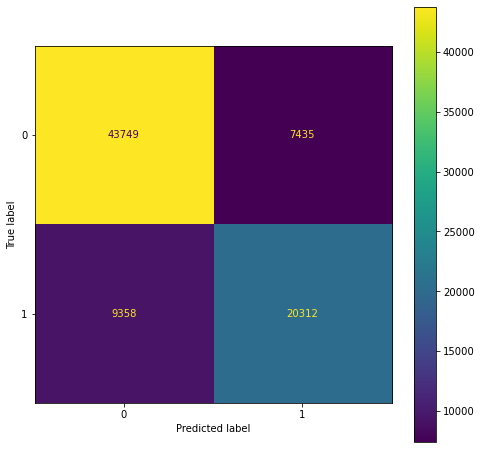

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, plot_confusion_matrix

C = [0.005, 0.01, 0.1, 0.5, 1.0, 5.0]

log_error_array = []

for i in C:
    clf_lr_tfidf= LogisticRegression(penalty='l2', C=i)
    sig_clf = CalibratedClassifierCV(clf_lr_tfidf)
    sig_clf.fit(X_train_lr_tfidf, y_train)
    predict_y = sig_clf.predict_proba(X_test_lr_tfidf)
    log_error_array.append(np.round(log_loss(y_test, predict_y), 4))
    print(f'For value of C: {i}, log-loss is {np.round(log_loss(y_test, predict_y), 4)}')

print('-'*50)

best_c_tfidf = C[np.argmin(log_error_array)]
clf = LogisticRegression(penalty='l2', C=best_c_tfidf)
sig_clf = CalibratedClassifierCV(clf)
sig_clf.fit(X_train_lr_tfidf, y_train)

predict_y = sig_clf.predict_proba(X_train_lr_tfidf)
logloss_train_lr_tfidf = np.round(log_loss(y_train, predict_y), 4)
print(f'For best value of C: {best_c_tfidf}, the train log-loss is {logloss_train_lr_tfidf}')

predict_y = sig_clf.predict_proba(X_test_lr_tfidf)
logloss_test_lr_tfidf = np.round(log_loss(y_test, predict_y), 4)
print(f'For best value of C: {best_c_tfidf}, the test log-loss is {logloss_test_lr_tfidf}')

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(sig_clf, X_test_lr_tfidf, y_test, values_format='.0f', ax=ax);

## 10.3. Logistic Regression (Bag of Words)

For value of C: 0.005, log-loss is 0.4431
For value of C: 0.01, log-loss is 0.433
For value of C: 0.1, log-loss is 0.4139
For value of C: 0.5, log-loss is 0.4137
For value of C: 1.0, log-loss is 0.4143
For value of C: 5.0, log-loss is 0.4143
--------------------------------------------------
For best value of C: 0.5, the train log-loss is 0.3916
For best value of C: 0.5, the test log-loss is 0.4137


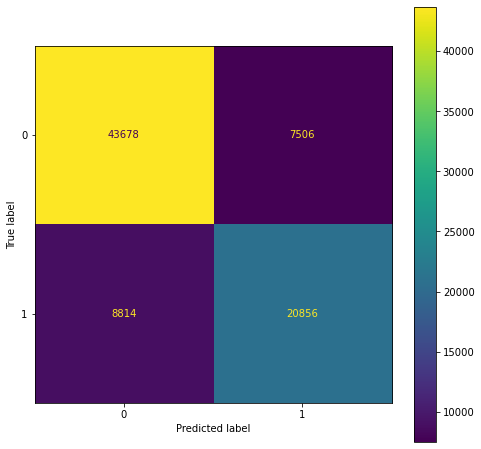

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, plot_confusion_matrix

C = [0.005, 0.01, 0.1, 0.5, 1.0, 5.0]

log_error_array = []

for i in C:
    clf_lr_bow= LogisticRegression(penalty='l2', C=i)
    sig_clf = CalibratedClassifierCV(clf_lr_bow)
    sig_clf.fit(X_train_lr_bow, y_train)
    predict_y = sig_clf.predict_proba(X_test_lr_bow)
    log_error_array.append(np.round(log_loss(y_test, predict_y), 4))
    print(f'For value of C: {i}, log-loss is {np.round(log_loss(y_test, predict_y), 4)}')

print('-'*50)

best_c_bow = C[np.argmin(log_error_array)]
clf = LogisticRegression(penalty='l2', C=best_c_bow)
sig_clf = CalibratedClassifierCV(clf)
sig_clf.fit(X_train_lr_bow, y_train)

predict_y = sig_clf.predict_proba(X_train_lr_bow)
logloss_train_lr_bow = np.round(log_loss(y_train, predict_y), 4)
print(f'For best value of C: {best_c_bow}, the train log-loss is {logloss_train_lr_bow}')

predict_y = sig_clf.predict_proba(X_test_lr_bow)
logloss_test_lr_bow = np.round(log_loss(y_test, predict_y), 4)
print(f'For best value of C: {best_c_bow}, the test log-loss is {logloss_test_lr_bow}')

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(sig_clf, X_test_lr_bow, y_test, values_format='.0f', ax=ax);

# 11. Model Performance 
## 11.1. Naive Bayes

In [14]:
from prettytable import PrettyTable
  
model_performance = PrettyTable(["Model", "Vectorizer", "Best Hyper-parameter (Alpha)" , "Log-loss on train data", "Log-loss on test data"])
  
# Add rows
model_performance.add_row(["Naive Bayes", "TFIDF", best_alpha_tfidf, logloss_train_nb_tfidf, logloss_test_nb_tfidf])
model_performance.add_row(["Naive Bayes", "Bag of Words", best_alpha_bow, logloss_train_nb_bow, logloss_test_nb_bow])

print(model_performance)

+-------------+--------------+------------------------------+------------------------+-----------------------+
|    Model    |  Vectorizer  | Best Hyper-parameter (Alpha) | Log-loss on train data | Log-loss on test data |
+-------------+--------------+------------------------------+------------------------+-----------------------+
| Naive Bayes |    TFIDF     |            0.005             |         0.5913         |         0.5907        |
| Naive Bayes | Bag of Words |            0.005             |         0.571          |         0.5717        |
+-------------+--------------+------------------------------+------------------------+-----------------------+


## 11.2. Logistic Regression

In [15]:
from prettytable import PrettyTable
  
model_performance = PrettyTable(["Model", "Vectorizer", "Best Hyper-parameter (C)" , "Log-loss on train data", "Log-loss on test data"])
  
# Add rows
model_performance.add_row(["Logistic Regression", "TFIDF", best_c_tfidf, logloss_train_lr_tfidf, logloss_test_lr_tfidf])
model_performance.add_row(["Logistic Regression", "Bag of Words", best_c_bow, logloss_train_lr_bow, logloss_test_lr_bow])

print(model_performance)

+---------------------+--------------+--------------------------+------------------------+-----------------------+
|        Model        |  Vectorizer  | Best Hyper-parameter (C) | Log-loss on train data | Log-loss on test data |
+---------------------+--------------+--------------------------+------------------------+-----------------------+
| Logistic Regression |    TFIDF     |           1.0            |         0.4101         |         0.422         |
| Logistic Regression | Bag of Words |           0.5            |         0.3916         |         0.4137        |
+---------------------+--------------+--------------------------+------------------------+-----------------------+
